# Проект для «Викишоп»




**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import spacy

from detoxify import Detoxify
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

## Загрузка и анализ данных

In [3]:
df = pd.read_csv(
    'datasets/toxic_comments.csv',
    index_col=[0]
    )

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df['text'].duplicated().sum()

np.int64(0)

Дубликатов в признаке text не обнаружено.

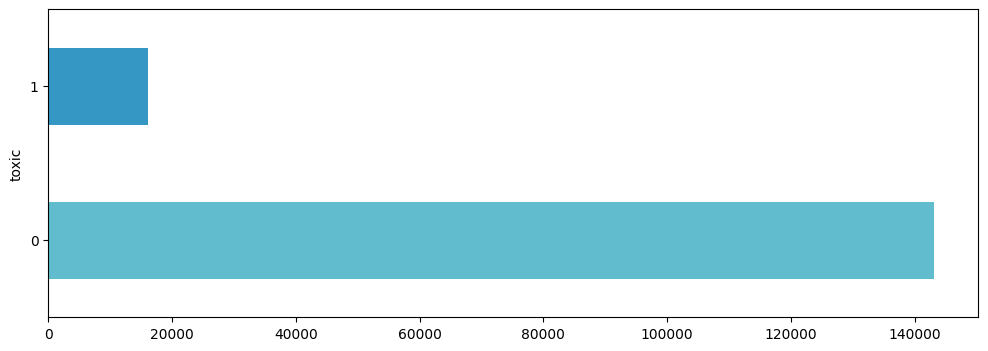

In [7]:
df['toxic'].value_counts().plot(kind='barh', figsize=(12, 4), color=sns.color_palette('GnBu')[3:5])
plt.show()

Наблюдается дисбаланс классов у целевого признака "toxic", примерно 8 к 1, для класса 0 к классу 1, однако при оценке точности предсказания модели, будет использована, устойчивая к дисбалансу, метрика F1-Score.

## Подготовка

Очистка текста и лемматизация:

In [8]:
corpus = df['text'].values

In [9]:
def lemmatize(corpus):
    result = []

    for text in tqdm(corpus, ascii=True, desc="Lemmatization text"):
        lemmas = [word.lemma_ for word in nlp(text)]
        result.append(" ".join(lemmas))

    print(f"ПРИМЕР ТЕКСТА ДО ЛЕММАТИЗАЦИИ:\n{corpus[0]}\n")
    print(f"ПРИМЕР ТЕКСТА ПОСЛЕ ЛЕММАТИЗАЦИИ:\n{result[0]}")
    return result

In [10]:
def clear_text(corpus):
    result = []

    for text in tqdm(corpus, ascii=True, desc='     Сlearing text'):
        text = re.sub(r"[^a-zA-z']", " ", text)
        text = text.split()
        text = " ".join(text)
        result.append(text)

    return result

Определения стоп-слов, с использованием библиотеки *Sp/acy*, для получения английских стоп-слов:

In [11]:
nlp = spacy.load('en_core_web_sm')
stopwords = list(nlp.Defaults.stop_words)

In [12]:
# Обработка 160к текстов в Colab занимает более часа
# заранее предобработанный pickle файл для удобства в работе с моделью
try:
    lemm_text = pd.read_pickle('datasets/lemm_text.pickle')
except:
    lemm_text = lemmatize(clear_text(corpus))

Формирование датасета из лемматизированного текста и целевого признака и деление на обучающие и тестовые выборки:

In [13]:
lemm_text_df = pd.DataFrame(lemm_text, columns=['text'])

In [14]:
res_data = pd.concat([lemm_text_df, df['toxic'].reset_index(drop=True)], axis=1)

In [15]:
X = res_data['text']
y = res_data['toxic']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

## Обучение

Создание пайплайна для подбора лучших гипперпараметров:

In [17]:
cv = KFold(n_splits=5)

In [18]:
pipe_final = Pipeline(
    [
        ('tfidf', TfidfVectorizer(stop_words=stopwords)),
        ('models', LogisticRegression())
    ]
)

param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5)
    },
]

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [19]:
random_search.fit(X_train, y_train)

c:\Users\kapit\Desktop\Разные файлы\Python\Practicum_GIT\.venv\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\kapit\Desktop\Разные файлы\Python\Practicum_GIT\.venv\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words=['however',
                                                                          'why',
                                                                          'whereupon',
                                                                          'your',
                                                                          'besides',
                                                                          'without',
                                                                          'side',
                                                                          'eight',
                                                                          'already',
                                                                          'a',
                                                                          'nothing',
                                                                          'hereupon',
                                                                          'n‘t',
                                                                          'due',
                                                                          'should',
                                                                          'whom',
                                                                          'thereupon',
                                                                          'me',
                                                                          'the',
                                                                          'he',
                                                                          'ours',
                                                                          'among',
                                                                          'themselves',
                                                                          'almost',
                                                                          'were',
                                                                          'if',
                                                                          'twelve',
                                                                          'too',
                                                                          'becoming',
                                                                          'his', ...])),
                                             ('models', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5)}],
                   random_state=42, scoring='f1')

In [20]:
pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__C,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,4.662914,0.103723,0.933825,0.047131,2,"LogisticRegression(penalty='l1', random_state=...","{'models__C': 2, 'models': LogisticRegression(...",0.784289,0.772979,0.785488,0.778526,0.784162,0.781089,0.004720,1
2,4.238791,0.518729,0.782445,0.083170,3,"LogisticRegression(penalty='l1', random_state=...","{'models__C': 3, 'models': LogisticRegression(...",0.785136,0.772121,0.785759,0.776020,0.786048,0.781017,0.005812,2
3,3.936430,0.110299,0.550884,0.022770,4,"LogisticRegression(penalty='l1', random_state=...","{'models__C': 4, 'models': LogisticRegression(...",0.783594,0.771701,0.786010,0.775755,0.784098,0.780232,0.005522,3
0,4.524873,0.131847,0.981968,0.050982,1,"LogisticRegression(penalty='l1', random_state=...","{'models__C': 1, 'models': LogisticRegression(...",0.777086,0.762774,0.771225,0.768999,0.779341,0.771885,0.005906,4


In [21]:
print(f'Лучша модель: {random_search.best_estimator_}')

Лучша модель: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['however', 'why', 'whereupon',
                                             'your', 'besides', 'without',
                                             'side', 'eight', 'already', 'a',
                                             'nothing', 'hereupon', 'n‘t',
                                             'due', 'should', 'whom',
                                             'thereupon', 'me', 'the', 'he',
                                             'ours', 'among', 'themselves',
                                             'almost', 'were', 'if', 'twelve',
                                             'too', 'becoming', 'his', ...])),
                ('models',
                 LogisticRegression(C=2, penalty='l1', random_state=42,
                                    solver='liblinear'))])


In [22]:
print(f'Лучша метрика на кросс-валидации: {random_search.best_score_}')

Лучша метрика на кросс-валидации: 0.7810888816339894


In [23]:
model = random_search.best_estimator_
pred = model.predict(X_test)
print(f'Лучша метрика на тестовых данных: {f1_score(y_test, pred)}')

Лучша метрика на тестовых данных: 0.7823662658999826


## Вывод

Был получен датасет со 160000 размечанных текстов по признаку токсичности. На этапе подготовки данных к обучению модели, тексты были очищены от не латинских символов и лемматизирванны. На этапе обучения была взята за основу модель логистичесской регрссии *LogisticRegression*, с помощью пайплайна тексты были трансформированы в TF-IDF матрицу. В ходе подбора гиерпараметров на кросс-валидации была выбрана лучшая модель - *LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')*, с результатом F1-score на тестовой выборке - 0.78.

## PS. Применение BERT модели

В качестве эксперимента решил применить модель BERT - *Detoxify*. Colab постоянно убивает ядро из-за нехватки ОЗУ, даже если брать 1% от генеральной совокупности, поэтому взял 250 записей, сформировал корпус, сделал предсказание токсичности и с помощью цикла подобрал порог классификации:

In [30]:
bert_data = df.sample(250, random_state=RANDOM_STATE).index
bert_data = df[df.index.isin(bert_data)]

In [31]:
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

In [32]:
bert_data['toxic'].value_counts(normalize=True)

toxic
0    0.896
1    0.104
Name: proportion, dtype: float64

In [33]:
bert_corpus = bert_data['text'].values

In [28]:
results = []
for text in tqdm(bert_corpus.tolist()):
    results.append(Detoxify('original').predict(text)['toxicity'])

  0%|          | 0/250 [00:00<?, ?it/s]

In [29]:
threshold = 0
best_score = 0
for t in range(1, 100, 1):
    t = t / 100
    bert_pred = list(map(lambda x: int(x > t), results))
    f1_res = f1_score(bert_data['toxic'], bert_pred)

    if f1_res > best_score:
        threshold = t
        best_score = f1_res

print(f"Порог классификации: {threshold}")
print(f"Лучший результат: {best_score}")

Порог классификации: 0.32
Лучший результат: 0.9811320754716981


С высокой долей вероятности эта модель обучалась на данном датасете и качество завышенное.